# Attempting price forecasting

In this notebook we attempt price forecasting to develop any methods that may be useful.

There are few notes, however I did discover the way `keras.preprocessing.timeseries_dataset_from_array()` works makes it not useful for creating datasets with small number of samples. Sequences and targets are only created from within the datasets provided. This keeps the training and validation data completely seperate which is good, however this is not the behaviour wanted for the test dataset. The way it works means that sequences are not created for `lookback + delay` timesteps between the training, validation and test sets.

I would like the test targets simulate running predictions from a hypothetical point in time. The final (best) model would be trained on all the data available up to that point and predictions would be made 24hrs (or the delay time) ahead going forward.

To make the test dataset work like this, only `delay` timesteps should be skipped between the end of the validation set and the start of the test set. There would be a small overlap in parts of some of the sequeunces.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')

bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")

bitcoin_df = pd.read_csv(bitcoin_csv)

bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

In [3]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                               35510.821213
closePriceUsd                              36119.489863
highPriceUsd                               36131.908921
lowPriceUsd                                35443.982726
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                   687.926195
Name: 0, dtype: object

In [4]:
# filtering the dates
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

In [5]:
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [6]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_polarity_zeros', 'bitcoin_subjectivity_zeros', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [7]:
timeperiod_df

,bitcoin_count,bitcoin_polarity,bitcoin_subjectivity,closePriceUsd,highPriceUsd,lowPriceUsd,volume
0,1557,0.198884,0.503805,36119.489863,36131.908921,35443.982726,62260118369
1,1393,0.195620,0.503729,35856.316167,36258.199088,35856.316167,63438090526
2,1250,0.211216,0.489562,35900.578564,36034.143364,35841.736712,63932631080
3,1323,0.197423,0.481759,36447.677556,36447.677556,35896.708862,64692363764
4,1289,0.201245,0.507788,36608.163042,36753.349106,36468.251444,66115147646
...,...,...,...,...,...,...,...
2395,4103,0.166638,0.510300,48648.455414,49336.249769,48123.340120,104063860569
2396,3523,0.169833,0.505377,49239.957814,49361.727178,48556.736299,105170038457
2397,4297,0.153253,0.509228,49540.843189,49753.798815,49077.319205,105720754888
2398,3089,0.164783,0.509559,49085.379170,49779.005678,49085.379170,100289782900


In [8]:
timeperiod_df.dtypes

bitcoin_count             int64
bitcoin_polarity        float64
bitcoin_subjectivity    float64
closePriceUsd           float64
highPriceUsd            float64
lowPriceUsd             float64
volume                    int64
dtype: object

I think I will go with a 70:20:10 split, and extend the dataset to 100 days, so that training on final model occurs on 90 days and test on the period following.

In [9]:
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
[[-0.62878269 -0.61195977  0.00844732 ... -2.64134751 -2.66053542
   0.04102602]
 [-0.80010675 -0.69099536  0.00577765 ... -2.62145087 -2.59590158
   0.12463137]
 [-0.94949297 -0.31329497 -0.48824611 ... -2.65675018 -2.59818693
   0.15973087]
 ...
 [ 0.20485513 -0.75563577 -0.0418961  ...  1.6477588   1.65802234
   0.50646338]
 [-0.20151719 -0.93671902 -0.65254185 ...  1.64757248  1.65282997
   0.49495658]
 [-0.37493057 -1.06443228 -1.06507662 ...  1.68590391  1.70600204
   0.58918177]]
[[-0.95385822]
 [-1.0701912 ]
 [-1.10035118]
 ...
 [ 0.57107035]
 [ 0.53912265]
 [ 0.48085021]]
1680
1680
Input shape: (128, 120, 7)
Target shape: (128, 1)


In [13]:
for group in val_dataset:
    data, targets = group
    print(len(data[2]))

120
120
120


In [15]:
for group in test_dataset:
    print(group)

In [16]:
timeperiod_df

,bitcoin_count,bitcoin_polarity,bitcoin_subjectivity,closePriceUsd,highPriceUsd,lowPriceUsd,volume
0,-0.628783,-0.611960,0.008447,-2.602363,-2.641348,-2.660535,0.041026
1,-0.800107,-0.690995,0.005778,-2.643752,-2.621451,-2.595902,0.124631
2,-0.949493,-0.313295,-0.488246,-2.636791,-2.656750,-2.598187,0.159731
3,-0.873233,-0.647326,-0.760378,-2.550750,-2.591599,-2.589570,0.213652
4,-0.908751,-0.554764,0.147343,-2.525511,-2.543441,-2.499980,0.314633
...,...,...,...,...,...,...,...
2395,2.030919,-1.392914,0.234946,-0.631952,-0.561043,-0.673029,3.008003
2396,1.425017,-1.315529,0.063240,-0.538927,-0.557029,-0.605093,3.086513
2397,2.233583,-1.717085,0.197539,-0.491607,-0.495259,-0.523491,3.125600
2398,0.971635,-1.437829,0.209075,-0.563238,-0.491288,-0.522228,2.740142


In [17]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(10, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(5, activation='relu'))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
13/13 [==============================] - 3s 218ms/step - loss: 0.4135 - val_loss: 0.1269
Epoch 2/10
13/13 [==============================] - 2s 170ms/step - loss: 0.2706 - val_loss: 0.1175
Epoch 3/10
13/13 [==============================] - 2s 167ms/step - loss: 0.1954 - val_loss: 0.1401
Epoch 4/10
13/13 [==============================] - 2s 172ms/step - loss: 0.1594 - val_loss: 0.1836
Epoch 5/10
13/13 [==============================] - 2s 165ms/step - loss: 0.1485 - val_loss: 0.2162
Epoch 6/10
13/13 [==============================] - 2s 162ms/step - loss: 0.1459 - val_loss: 0.2287
Epoch 7/10
13/13 [==============================] - 2s 170ms/step - loss: 0.1434 - val_loss: 0.2303
Epoch 8/10
13/13 [==============================] - 2s 164ms/step - loss: 0.1404 - val_loss: 0.2281
Epoch 9/10
13/13 [==============================] - 2s 170ms/step - loss: 0.1374 - val_loss: 0.2246
Epoch 10/10
13/13 [==============================] - 2s 168ms/step - loss: 0.1347 - val_loss: 0.2209

In [18]:
#https://www.kite.com/python/answers/how-to-find-the-indices-of-rows-in-a-pandas-dataframe-containing-nan-values-in-python
rows_with_nan = []
for index, row in timeperiod_df.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

print(rows_with_nan)

[]


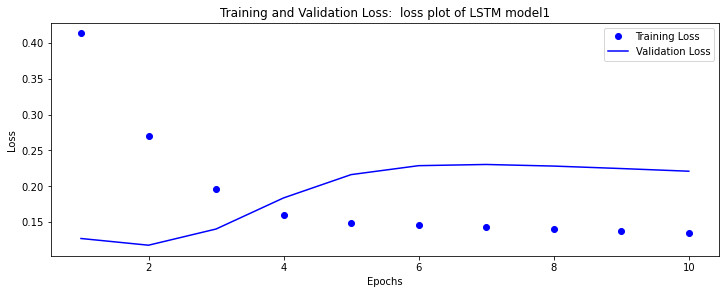

In [19]:
plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

In [20]:
LSTM_model1_history.history['val_loss']

[0.12690794467926025,
 0.11752530932426453,
 0.14013974368572235,
 0.1836100071668625,
 0.21616849303245544,
 0.2286672443151474,
 0.23033560812473297,
 0.22809086740016937,
 0.2246362566947937,
 0.2209068089723587]

In [21]:
results = LSTM_model1.evaluate(val_dataset)

3/3 [==============================] - 0s 63ms/step - loss: 0.2209


In [22]:
results = LSTM_model1.predict(val_dataset)

In [23]:
# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
y = np.concatenate([y for x, y in val_dataset], axis=0)
print(y)

[[ 0.28708464]
 [ 0.34069874]
 [ 0.24711347]
 [ 0.33599896]
 [ 0.41064933]
 [ 0.355429  ]
 [ 0.15822164]
 [ 0.24560326]
 [ 0.39321039]
 [ 0.3571769 ]
 [ 0.52193099]
 [ 0.56603506]
 [ 0.4994136 ]
 [ 0.56953378]
 [ 0.44052308]
 [ 0.42491836]
 [ 0.49367148]
 [ 0.51629144]
 [ 0.56836048]
 [ 0.61711954]
 [ 0.65547507]
 [ 0.68134222]
 [ 0.5919412 ]
 [ 0.59860738]
 [ 0.47506514]
 [ 0.53849033]
 [ 0.55390612]
 [ 0.41910887]
 [ 0.44648071]
 [ 0.41918408]
 [ 0.46226207]
 [ 0.40709135]
 [ 0.44393455]
 [ 0.46757299]
 [ 0.35996999]
 [ 0.31190746]
 [ 0.44006436]
 [ 0.46115602]
 [ 0.55470888]
 [ 0.54544664]
 [ 0.48731558]
 [ 0.4638387 ]
 [ 0.42326884]
 [ 0.46035833]
 [ 0.37353505]
 [ 0.3470873 ]
 [ 0.22452988]
 [ 0.19490795]
 [ 0.22395784]
 [ 0.22521251]
 [ 0.18402409]
 [ 0.13480112]
 [ 0.24865804]
 [ 0.296383  ]
 [ 0.28916786]
 [ 0.250074  ]
 [ 0.13009532]
 [ 0.25940448]
 [ 0.20059193]
 [ 0.34821762]
 [ 0.37712166]
 [ 0.28419748]
 [ 0.32848699]
 [ 0.30746587]
 [ 0.35455255]
 [ 0.13210155]
 [ 0.12737

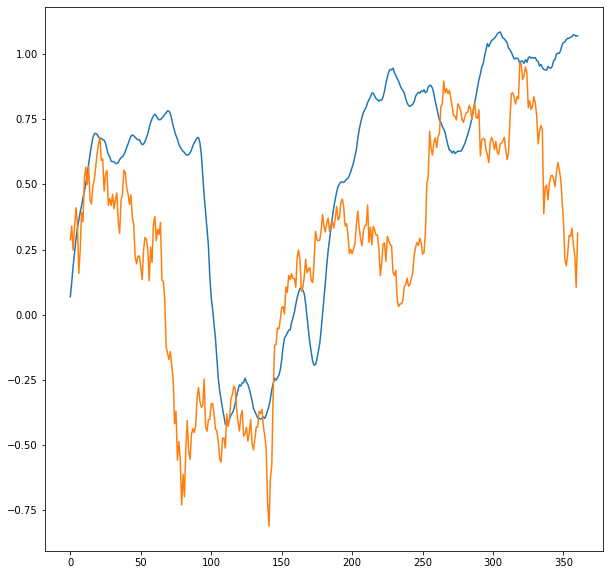

In [24]:
fig = plt.figure(figsize=(10,10))
plt.plot(results)
plt.plot(y)

In [25]:
print(len(y), len(results))

361 361


In [26]:
combined_dataset = train_dataset.concatenate(val_dataset)

Now to work out evaluation methods.
https://otexts.com/fpp2/accuracy.html

MAPE = mean absolute percentage error

RMSE = root mean squared error


In [27]:
absolute_errors = np.abs(y - results)

rmse = np.sqrt(np.mean(absolute_errors**2))
mape = np.mean((absolute_errors/y)*100)
print(rmse)
print(mape)

#------------------------------------
# checking array calculations work (same as iter)
ape_sum = 0
se_sum =0
for i in range(0, len(y)):
    abs_error = np.abs(y[i]-results[i])
    se = abs_error**2
    ape = abs_error / y[i]
    ape_sum = ape_sum + ape
    se_sum = se_sum + se

rmse = np.sqrt(se_sum/len(y))[0]
mape = (ape_sum / len(y))[0]
print(rmse)
print(mape)

0.47000726557356615
96.13294429487635
0.47000726557356637
0.961329442948763


In [28]:
np.mean(absolute_errors**2)

0.22090682969194075

the test dataset is empty...

In [60]:
test_data = timeperiod_df[(training_samples+validation_samples) - lookback:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=120,
        sampling_rate=1,
        batch_size=128,
    )

In [61]:
results = LSTM_model1.predict(test_dataset)

In [62]:
test_targets = test_targets.to_numpy()
print(len(test_targets))
print(len(results))

216
216


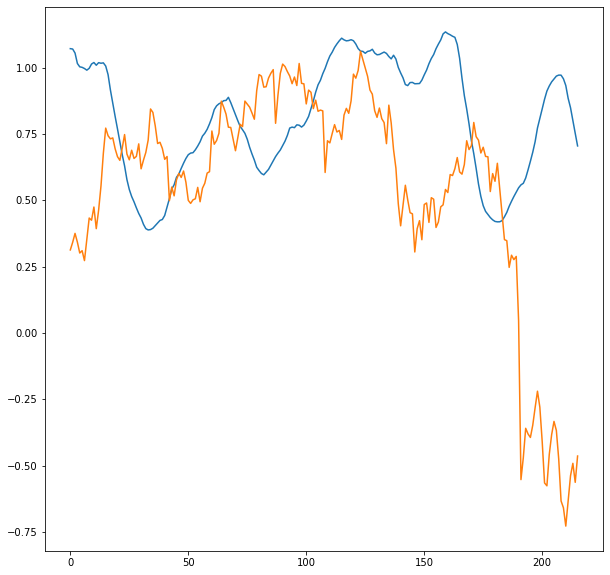

In [63]:
fig = plt.figure(figsize=(10,10))
plt.plot(results)
plt.plot(test_targets)